In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

Для реализации задачи обучение модели не требуется. Используем сразу валидационный датасет

In [22]:
valid = pd.read_csv("../../data/preprocessed/cosine/valid.csv")
reference = pd.read_csv("../../data/preprocessed/cosine/reference.csv")

In [23]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [24]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         305 non-null    int64 
 1   reference  305 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


### Преобразования в np.array

In [25]:
x = valid["name"].to_numpy(dtype="str").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="str").flatten()

### Функции расчета метрик и simple-предсказаний

In [26]:
def accuracy_top_k(y_true, y_pred, k):
    correct = 0
    valid_count = 0  # Счетчик для валидных предсказаний
    for true_id, pred_list in zip(y_true, y_pred):
        top_k_ids = [pred[0] for pred in pred_list[:k] if pred[0] is not None]
        if top_k_ids:
            valid_count += 1
            if true_id in top_k_ids:
                correct += 1
    return correct / valid_count if valid_count > 0 else 0


def check_top_1(true_values, predictions):
    result = []
    for pred_list, true in zip(predictions, true_values):
        if pred_list[0][0] == true:
            result.append(False)
        else:
            result.append(True)
    return result


def calculate_metrics(true_values, predictions, manual_review, cost=1):
    # Accuracy
    accuracy_top_1 = accuracy_top_k(true_values, predictions, 1)
    accuracy_top_3 = accuracy_top_k(true_values, predictions, 3)
    accuracy_top_5 = accuracy_top_k(true_values, predictions, 5)

    # Бизнес-метрика: процент ошибок автоматической обработки
    auto_error_rate = 1 - accuracy_top_1

    # Бизнес-метрика: доля данных, отправленных на ручную обработку данных
    manual_processing_rate = len(manual_review) / len(predictions)

    # manual_spend = len(manual_review) * cost

    # correction_spend = (len(true_values) - len(manual_review)) * cost * 1.5

    # general_error = (
    #     (len(true_values) - len(manual_review)) * auto_error_rate / len(true_values)
    # )

    general_error = (1 - manual_processing_rate) * auto_error_rate

    return {
        "Accuracy@1": round(accuracy_top_1, 3),
        "Accuracy@3": round(accuracy_top_3, 3),
        "Accuracy@5": round(accuracy_top_5, 3),
        "auto_error_rate": round(auto_error_rate, 3),
        "manual_processing_rate": round(manual_processing_rate, 3),
        "general_error": round(general_error, 3),
        # "manual_spend": manual_spend,
        # "correction_spend": correction_spend,
        # "general_spend": manual_spend+correction_spend,
    }

# Построение модели

In [27]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x, reference_name))
x_vec = vectorizer.transform(x)
reference_vec = vectorizer.transform(reference_name)

In [40]:
x_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 947 stored elements and shape (184, 478)>

In [28]:
def find_matches_cosine(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []
    for x in x_vec:
        similarities = cosine_similarity(x, reference_vec).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства
        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        y_pred.append(top_matches)
    return y_pred, manual_review

In [49]:
# Массив значений threshold
threshold_values = np.linspace(-0.1, 1.0, 10)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_cosine(
        x_vec, reference_id, reference_vec, top_k=5, threshold=threshold
    )
    metrics = calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

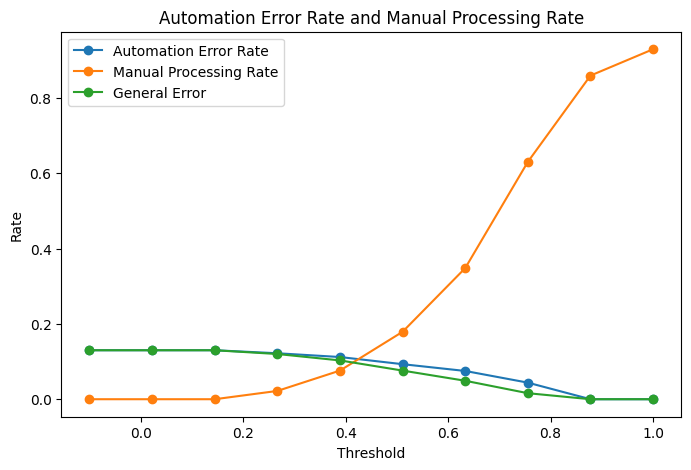

In [50]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [63]:
y_pred, manual_review = find_matches_cosine(
    x_vec, reference_id, reference_vec, top_k=5, threshold=-1
)

metrics = calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.87,
 'Accuracy@3': 0.946,
 'Accuracy@5': 0.967,
 'auto_error_rate': 0.13,
 'manual_processing_rate': 0.0,
 'general_error': 0.13}

In [59]:
y_pred_2 = []

for i, candidate_list in enumerate(y_pred):
    answer = candidate_list[0][0]
    y_pred_2.append(answer)


In [60]:
pd.set_option("display.max_rows", None)
# pd.set_option('display.max_rows', 50)


In [61]:
result = pd.DataFrame({"valid": y, "main_model": y_pred_2, "main_model2": y_pred})
result


,valid,main_model,main_model2
0,198,220,"[(220, 0.7253292704768104), (198, 0.6538465250..."
1,184,184,"[(184, 0.7852690576405115), (1841, 0.229811830..."
2,293,293,"[(293, 1.0), (20, 0.5752828110064621), (21, 0...."
3,277,277,"[(277, 0.8044032291183056), (48, 0.49033199938..."
4,35,35,"[(35, 0.760426771289441), (3461, 0.34366592683..."
5,1843,1843,"[(1843, 0.9223880014018111), (611, 0.297054485..."
6,110,110,"[(110, 0.7451713854961349), (64, 0.27685801100..."
7,11,11,"[(11, 0.8462511262161606), (200, 0.62086522282..."
8,128,204,"[(204, 0.6408877794296024), (1846, 0.584220389..."
9,25,25,"[(25, 0.6074772888564139), (292, 0.43657411644..."


Цель - не более 5% ручного разбора и не менее 95% точности автоматического разбора. Итоговая ошибка составит 4,7%.

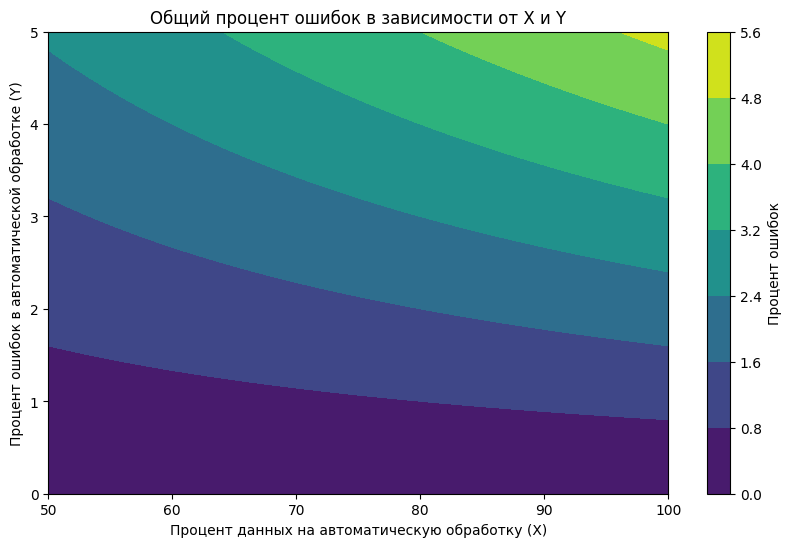

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Общее количество данных
total_data = 200

# Диапазоны значений для X и Y
X_values = np.linspace(0.5, 1, 100)  # 0% до 100%
Y_values = np.linspace(0, 0.05, 10)  # 0% до 10%

# Матрица для хранения процентов ошибок
error_percentages = np.zeros((len(X_values), len(Y_values)))

# Расчеты
for i, X in enumerate(X_values):
    for j, Y in enumerate(Y_values):
        automatic_data = total_data * X
        errors_in_automatic = automatic_data * Y
        total_errors_percentage = (errors_in_automatic / total_data) * 100
        error_percentages[i, j] = total_errors_percentage

# Создание графика
X_grid, Y_grid = np.meshgrid(
    X_values * 100, Y_values * 100
)  # Преобразование в проценты для осей
plt.figure(figsize=(10, 6))
contour = plt.contourf(X_grid, Y_grid, error_percentages.T, cmap="viridis")
plt.colorbar(contour, label="Процент ошибок")
plt.xlabel("Процент данных на автоматическую обработку (X)")
plt.ylabel("Процент ошибок в автоматической обработке (Y)")
plt.title("Общий процент ошибок в зависимости от X и Y")
plt.show()